In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cp

from tqdm import tqdm
from scipy import stats
# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'


import utils
from stuff import Model, ADOM_affine

$$f_i(x) = \frac12 x^T C_i x + d_i^T x, \;  \mu I \preceq C_i \preceq L I$$
$$f(x) = \sum^n f_i(x)$$

slope ($a = -\kappa$). linreg $y = ax + c$:
$$\ln \varepsilon(n) = a n + c $$
$$\varepsilon(n) = e^c \cdot \exp(a n)$$

param ($p$). linreg $y=kx + b$:

$$\ln -a = k \ln p + b$$

$$a = -e^b \cdot p^k$$

finally

$$\varepsilon(n) = e^{c} \cdot \exp(-e^b p^k n)$$



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


CPU times: user 28.2 s, sys: 2min 29s, total: 2min 57s
Wall time: 11.8 s


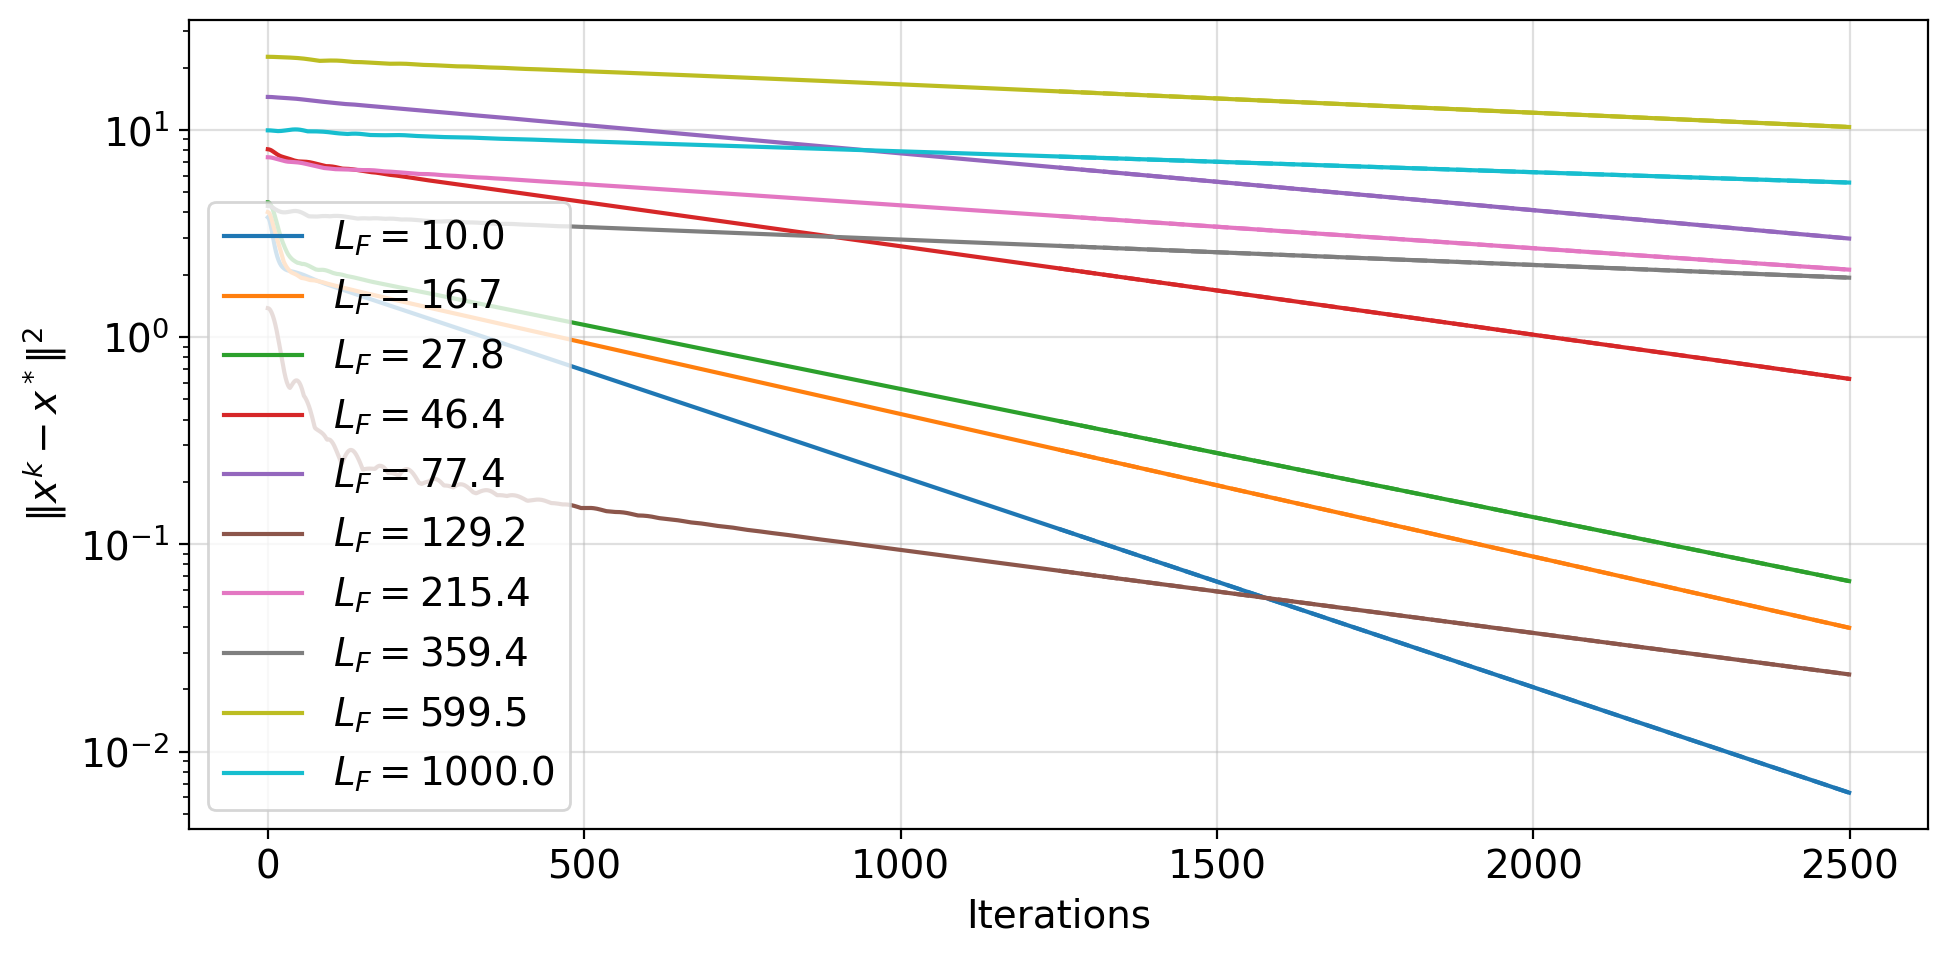

In [3]:
%%time
plt.figure(figsize=(10,5))

iters = 2500
Ls = np.logspace(1, 3, 10)
distlogs = []
ress = []
skip = 0.5

params = Ls
ax = plt.gca()
for param in tqdm(params):
    model = Model(nodes=5, dim=20, mu=1 , L=param , lmaxATA=20, cons_rows=10, graph_model="ring")
    g, z_f, flog, errlog, affinelog, distlog = ADOM_affine(iters, model, inner_steps=int(param / 100) + 1)
    distlogs.append(distlog)
    x = np.arange(int(iters * skip), iters)
    res = stats.linregress(x, np.log(distlog[int(iters * skip): ]))
    ress.append(res)
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(distlog, label=f"$L_F={param:.1f}$", color=color)
    plt.plot(x, np.exp(res.intercept + x * res.slope), '--', color=color,)
    
plt.xlabel("Iterations")
plt.ylabel(r"$\|x^k - x^*\|^2$")
plt.legend()
plt.yscale("log")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("convs.pdf")
# plt.ylim(0.08, 30)

[0.00234703 0.00158465 0.00142424 0.00098279 0.00063132 0.00092275
 0.00047725 0.00028279 0.00031741 0.00023174]
LinregressResult(slope=-0.49703870283742707, intercept=-4.9691086177070956, rvalue=-0.97156096107323, pvalue=2.7652784421351203e-06, stderr=0.04282897894098493, intercept_stderr=0.20703558989273949)


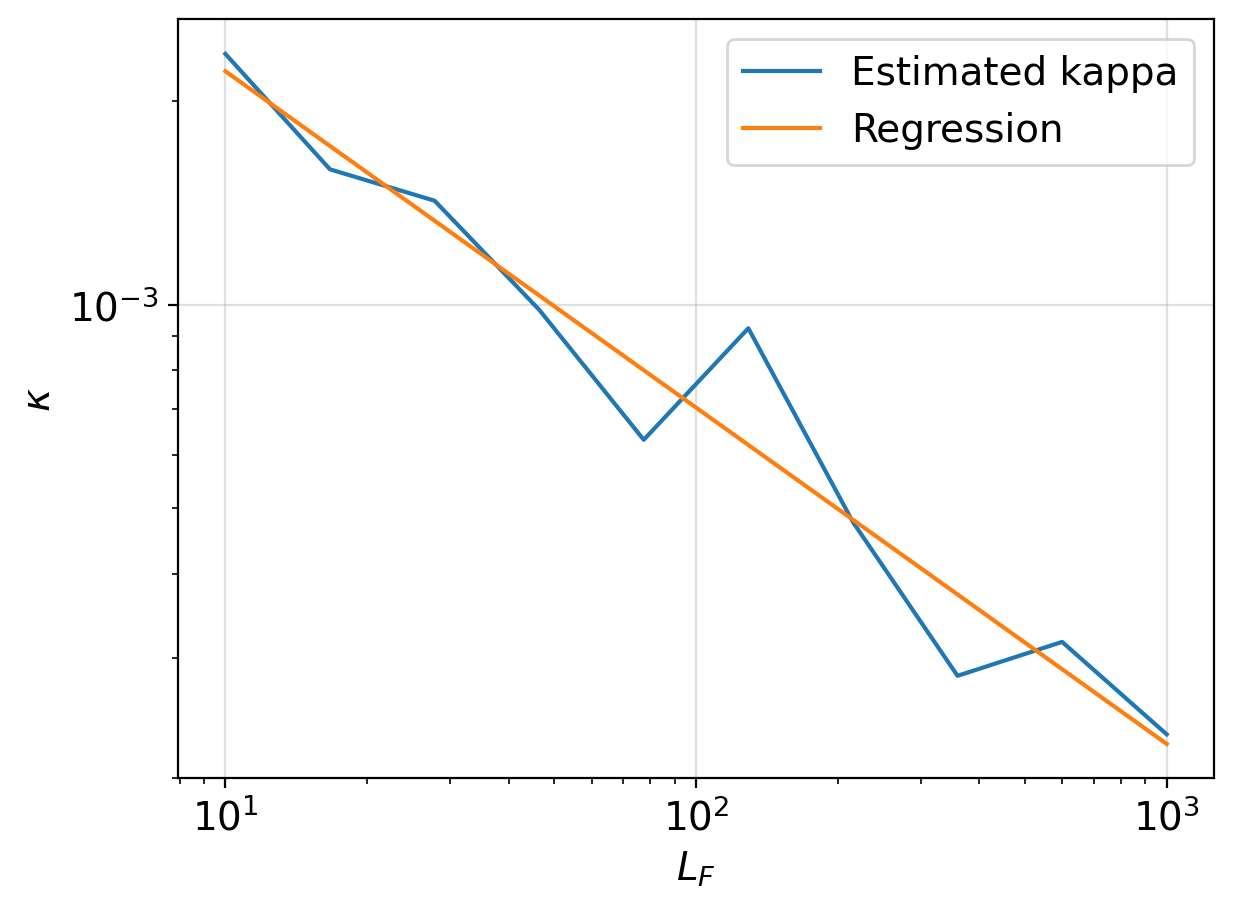

In [4]:
slopes = -np.array([res.slope for res in ress])
print(slopes)

mask = slopes > 0 # can be < 0 for large L
slopes = slopes[mask]
params = params[mask]

# plt.plot(params, slopes, label="Estimated $\kappa$")
plt.plot(params, slopes, label="Estimated kappa")
res = stats.linregress(np.log(params), np.log(slopes))
print(res)
plt.plot(params, np.exp(res.intercept) * params ** res.slope, label="Regression")
plt.xlabel("$L_F$")
plt.ylabel("$\kappa$")
plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("nu.pdf")